# Prepare working environnment

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from joblib import dump, load

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
# Load datasets
data_train = pd.read_pickle('../data/data_outputs/feature_engineered/cleaned_dataset.pkl')
data_test = pd.read_pickle('../data/data_outputs/feature_engineered/cleaned_dataset_test.pkl')

In [31]:
# Drop unnecessary columns
l_drop = ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index', 'source']
feats = [f for f in data_train.columns if f not in l_drop]

train_targets = data_train['TARGET']
test_ids = data_test['SK_ID_CURR']
data_train = data_train[feats]
data_test = data_test[feats]

In [4]:
# Load trained classifiers
l_classifiers = load('../data/data_outputs/LGBM_classifiers.joblib')

In [5]:
# Testing classifiers
for i in range(len(l_classifiers)):
    y_pred = l_classifiers[i].predict_proba(data_test.iloc[0].values.reshape(1, -1))
    print(y_pred)

[[0.9725953 0.0274047]]
[[0.97867603 0.02132397]]
[[0.97195938 0.02804062]]
[[0.96860935 0.03139065]]
[[0.97676399 0.02323601]]


# Shap with one classifier

In [6]:
# Select a classifier
model = l_classifiers[0]

In [7]:
# Tree explainer on a subsample
data_sample = data_train.iloc[:10000].copy()
TreeExp = shap.TreeExplainer(model)
shap_values = TreeExp.shap_values(data_sample)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## On a subsample of predictions

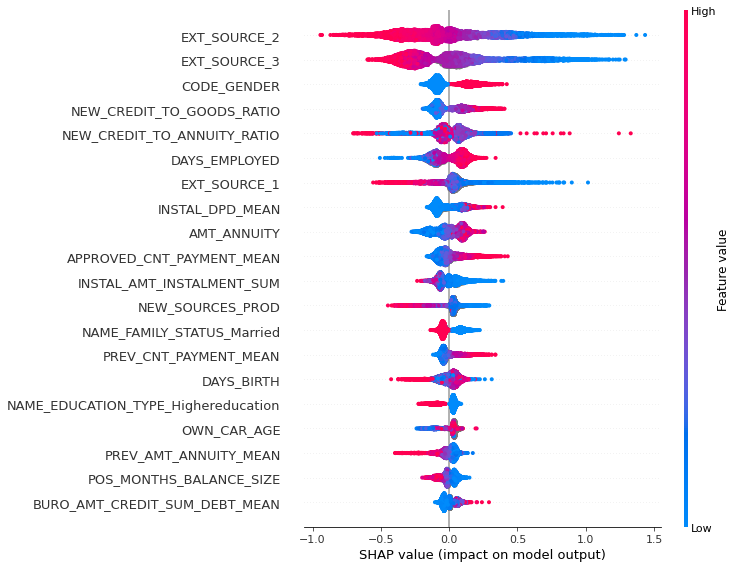

In [8]:
# Summary plot
shap.summary_plot(shap_values[1], data_sample)

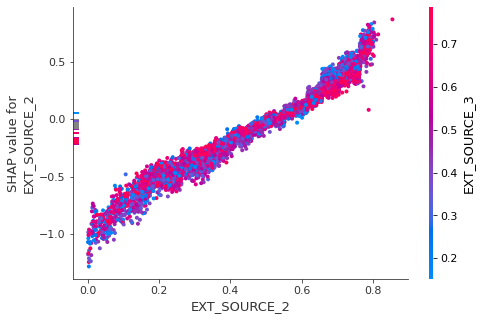

In [9]:
shap.dependence_plot('EXT_SOURCE_2', shap_values[0], data_sample)

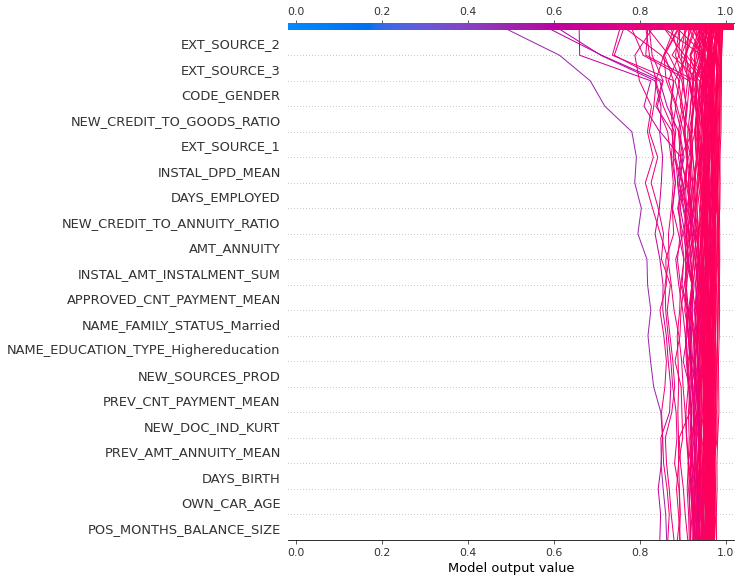

In [10]:
# Decision plot
shap.decision_plot(TreeExp.expected_value[0], shap_values[0][:100], data_sample.columns, link = 'logit')

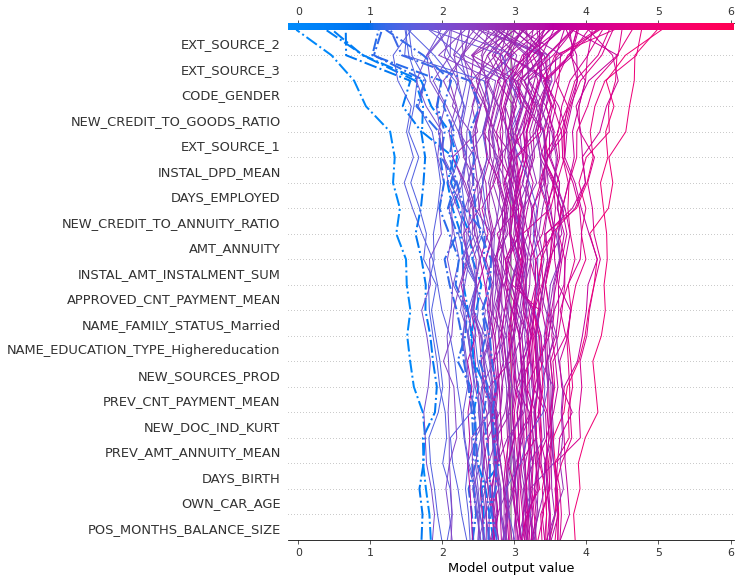

In [11]:
# Highlight applications with a predicted probability of failure above 20%
shap.decision_plot(TreeExp.expected_value[0], shap_values[0][:100], data_sample.columns, 
                   highlight =(model.predict_proba(data_sample[:100])[:,1]>0.2)
                  )

## On a single prediction

In [12]:
# Force plot
shap.initjs()
shap.force_plot(TreeExp.expected_value[0], shap_values[0][0], data_sample.iloc[0])

In [13]:
# Force plot converted in probabilities
shap.force_plot(TreeExp.expected_value[0], shap_values[0][0], data_sample.iloc[0], link = 'logit')

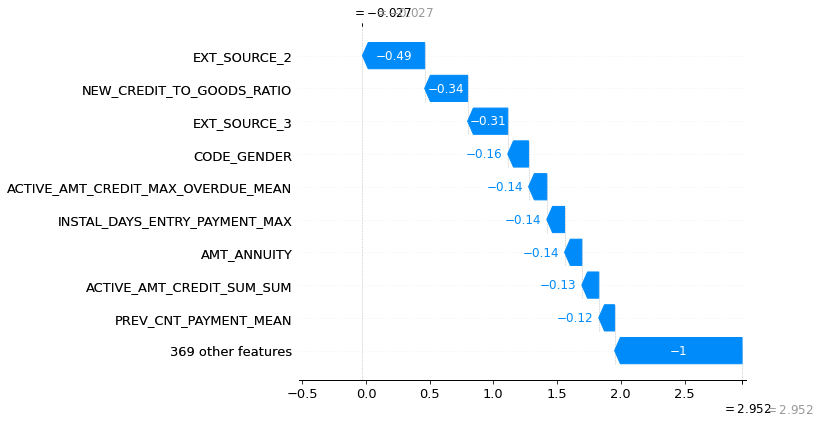

0.5068490830697027


In [14]:
# Waterfall on a positive prediction
i_positive = (model.predict(data_sample)==1).tolist().index(True)

TreeExp.base_values=TreeExp.expected_value[0]
TreeExp.feature_names = data_sample.columns
TreeExp.values= shap_values[0][i_positive]

shap.plots.waterfall(TreeExp)
print(model.predict_proba(data_sample)[i_positive, 1])

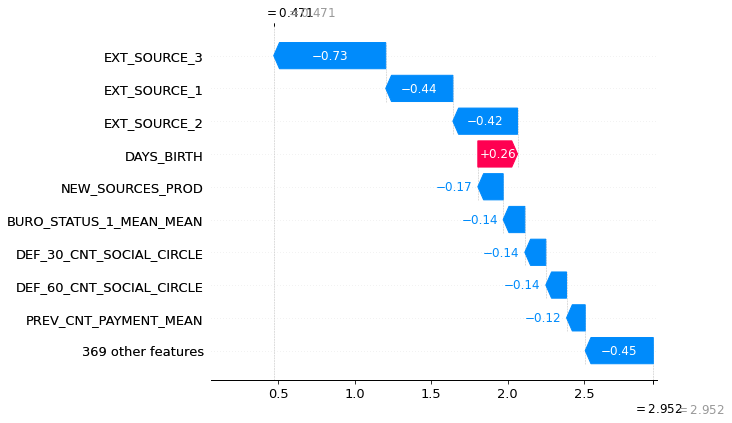

0.38448383727896684


In [15]:
# Waterfall on a negative prediction
i_negative = (model.predict(data_sample)==1).tolist().index(False)

TreeExp.base_values=TreeExp.expected_value[0]
TreeExp.feature_names = data_sample.columns
TreeExp.values= shap_values[0][i_negative]

shap.plots.waterfall(TreeExp)
print(model.predict_proba(data_sample)[i_negative, 1])

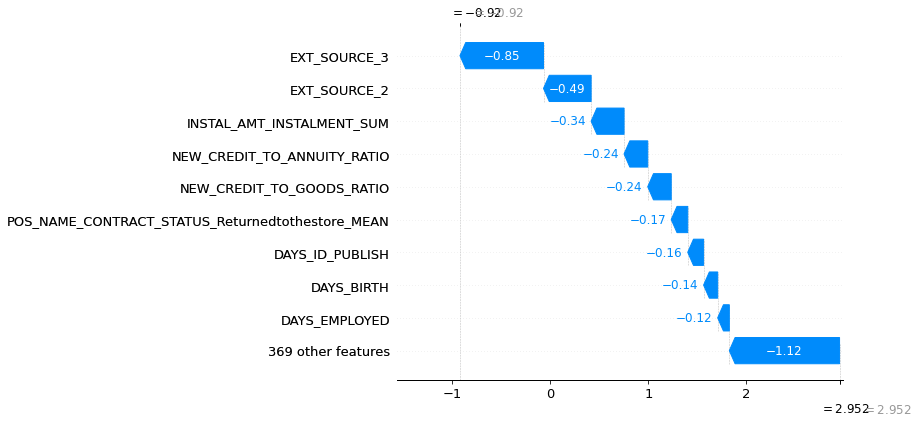

0.71503829474472


In [16]:
# High probability of failure
i_high = (model.predict_proba(data_sample)[:,1]>0.7).tolist().index(True)
TreeExp.values= shap_values[0][i_high]

shap.plots.waterfall(TreeExp)
print(model.predict_proba(data_sample)[i_high, 1])

In [17]:
shap.force_plot(TreeExp.expected_value[0], shap_values[0][i_high], data_sample.iloc[i_high])

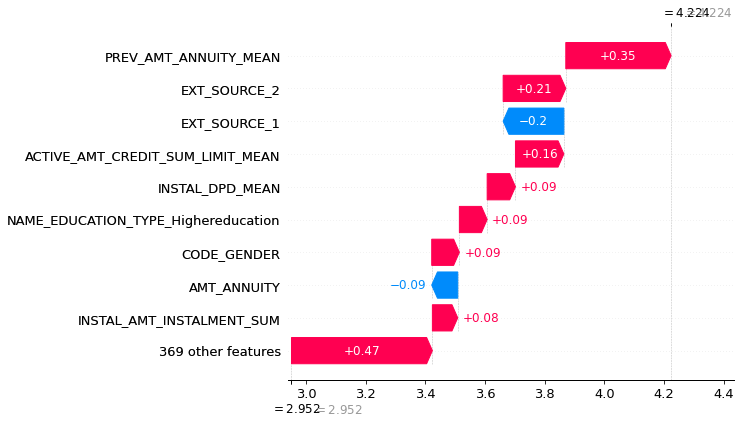

0.014433803306752183


In [18]:
# low probability of failure
i_low = (model.predict_proba(data_sample)[:,1]<0.2).tolist().index(True)
TreeExp.values= shap_values[0][i_low]

shap.plots.waterfall(TreeExp)
print(model.predict_proba(data_sample)[i_low, 1])

In [19]:
shap.force_plot(TreeExp.expected_value[0], shap_values[0][i_low], data_sample.iloc[i_low], link = 'logit')

# Combine shap values from all classifiers, on data_test

In [20]:
data_test.shape

(48744, 378)

In [21]:
# Retrieve explainers and shap values (for class 0) for all classifiers
l_explainers = []
l_shap_values = []

for i, clf in enumerate(l_classifiers) :
    print(f'Processing classifier n°{i}')
    explainer = shap.TreeExplainer(clf)
    shap_clf = explainer.shap_values(data_test)
    
    l_explainers+=[explainer]
    l_shap_values+=[shap_clf[0]]

Processing classifier n°0


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Processing classifier n°1
Processing classifier n°2
Processing classifier n°3
Processing classifier n°4


In [22]:
# Combine shap values
mean_shap = sum(l_shap_values)/5
np.shape(mean_shap)

(48744, 378)

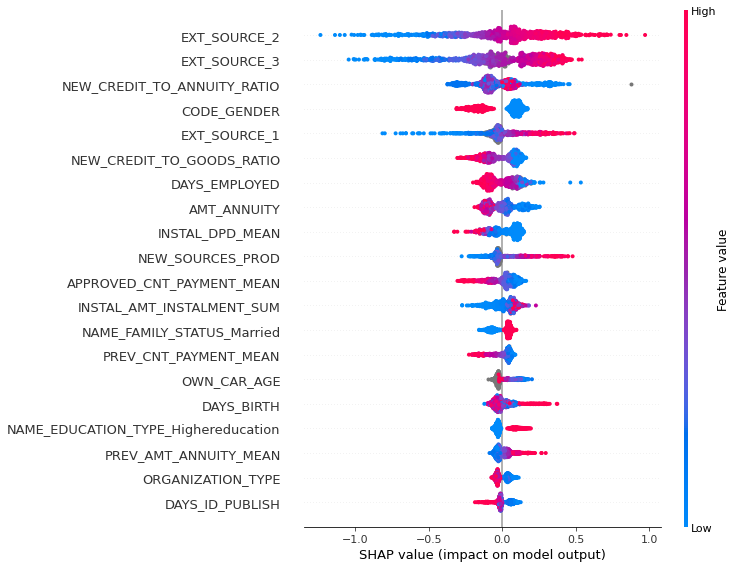

In [23]:
# Summary plot for mean_shap
shap.summary_plot(mean_shap[:1000], data_test[:1000])

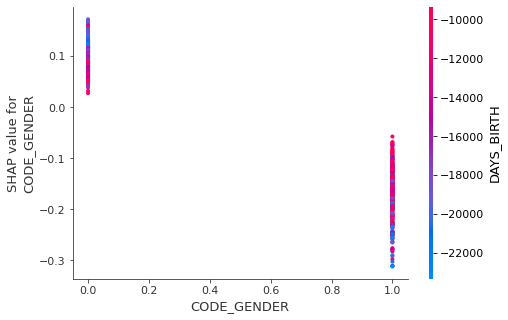

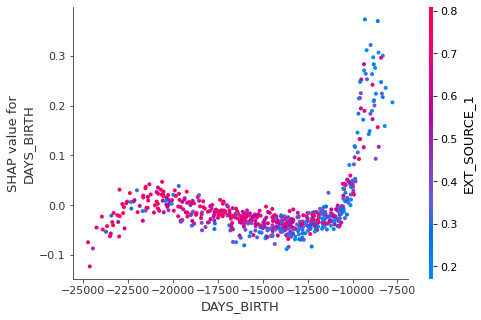

In [24]:
shap.dependence_plot('CODE_GENDER', mean_shap[:1000], data_test[:1000])
shap.dependence_plot('DAYS_BIRTH', mean_shap[:1000], data_test[:1000])

In [25]:
# Expected value
mean_expected = sum([x.expected_value[0] for x in l_explainers])/5
shap.force_plot(mean_expected, mean_shap[0], data_sample.iloc[0], link = 'logit')

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.05153455e-05, 2.05153455e-05, 2.05153455e-05,
        2.05153455e-05, 2.05153455e-05, 2.05153455e-05, 2.05153455e-05,
        2.05153455e-05, 2.05153455e-05, 4.10306910e-05, 4.10306910e-05,
        8.20613819e-05, 1.23092073e-04, 1.23092073e-04, 1.43607418e-04,
        2.66699491e-04, 3.07730182e-04, 3.48760873e-04, 4.10306910e-04,
        5.33398982e-04, 5.53914328e-04, 6.35975710e-04, 7.79583128e-04,
        9.02675201e-04, 9.84736583e-04, 1.25143607e-03, 1.41555884e-03,
        1.62071229e-03, 1.92844247e-03, 2.27720335e-03, 2.56441818e-03,
        2.97472509e-03, 3.59018546e-03, 3.89791564e-03, 4.47234531e-03,
        5.06729033e-03, 5.80584277e-03, 6.46233383e-03, 7.344493

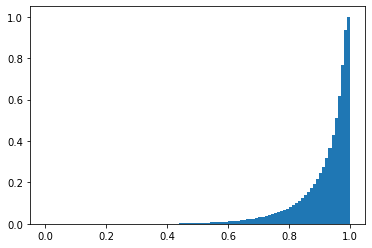

In [26]:
plt.hist(model.predict_proba(data_test)[:,0], bins = np.linspace(0,1,101), density = True, cumulative=True)

In [32]:
# Create a dataframe containing clients ID and shap_values
df_shap = pd.DataFrame(mean_shap, columns = data_test.columns, index = test_ids)
df_shap

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,...,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,PREV_CHANNEL_TYPE_Contactcenter_MEAN,PREV_CHANNEL_TYPE_Countrywide_MEAN,PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN,PREV_CHANNEL_TYPE_RegionalLocal_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_CHANNEL_TYPE_nan_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_NAME_YIELD_GROUP_nan_MEAN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_DAYS_DECISION_MAX,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_APPLICATION_MAX,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_DAYS_DECISION_MAX,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_DEF_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_

In [33]:
# Store as csv
df_shap.to_csv('test_shap_values.csv')

In [37]:
data_test.join(test_ids).to_csv('data_test.csv')